In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from astropy.table import Table
%matplotlib inline

In [2]:
data_path = "../surveysim/output/"
plan_files = glob.glob(os.path.join(data_path, "plan_*"))
progress_files = glob.glob(os.path.join(data_path, "progress_*"))
progress_files = sorted(progress_files)
plan_files = sorted(plan_files)

In [3]:
a = Table.read(plan_files[-1])
b = Table.read(progress_files[-1])
print(a[:10])
print(b[:10])
print(a.keys())
print(b.keys())

tileid   ra    dec  pass group priority active   hourangle   
------ ------ ----- ---- ----- -------- ------ --------------
     4 335.03 19.88    0     2        6  False -8.62037277222
     6 333.22 14.84    0     2        6  False -10.1858892441
     7 332.35 12.32    0     2        6  False -8.91088867188
     8  319.9  6.05    0     2        6  False -18.1183185577
     9 330.67  7.31    0     2        6  False -9.06365966797
    10 329.84   4.8    0     2        9  False  -8.4949054718
    11  326.4  1.37    0     2        9  False -10.0686321259
    12 326.88  4.31    0     2        9  False -8.83903598785
    13 324.73  5.92    0     2        6  False -14.3890371323
    14 322.58  7.47    0     2        6  False -12.4090747833
tileid pass   ra   ...       moonalt [32]          moonsep [32]    
                   ...           deg                   deg         
------ ---- ------ ... ----------------------- --------------------
     4    0 335.03 ... -0.0532379448414 .. 0.0 71.81

In [4]:
tiling_file = os.path.join(os.environ['DESIMODEL'], 'data/footprint/', 'desi-tiles.fits')
tiling_data = Table.read(tiling_file)
print(tiling_data.keys())

#get the program of the unobserved tiles
program = tiling_data['PROGRAM'][np.in1d(tiling_data['TILEID'], b['tileid'][b['status']==0])]
n_all = len(b)
print(n_all)
print('indesi', np.count_nonzero(tiling_data['IN_DESI']!=0))
print(np.count_nonzero(program=='DARK')/n_all, 
      np.count_nonzero(program=='BRIGHT')/n_all, 
      np.count_nonzero(program=='GRAY')/n_all)

['TILEID', 'RA', 'DEC', 'PASS', 'IN_DESI', 'EBV_MED', 'AIRMASS', 'STAR_DENSITY', 'EXPOSEFAC', 'PROGRAM', 'OBSCONDITIONS']
16071
indesi 20070
0.12363885259162466 0.0 0.0


In [5]:
n_progress = len(progress_files)
n_epoch = n_progress - 1
for i in range(n_epoch):
    plan_data = Table.read(plan_files[i])
    progress_data = Table.read(progress_files[i+1])
    previous_progress_data = Table.read(progress_files[i])
    
    plan_tileid = plan_data['tileid'][plan_data['active']==True]
    progress_tileid = progress_data['tileid'][progress_data['status']==2]
    previous_progress_tileid = previous_progress_data['tileid'][previous_progress_data['status']==2]
    observed_tiles = np.array(list(set(progress_tileid) - set(previous_progress_tileid)))
    
    match = plan_tileid[np.in1d(plan_tileid, observed_tiles)]
    if(len(match)!=len(observed_tiles)):
        print('Problem!')
    print(i, n_epoch, len(plan_tileid), len(observed_tiles), len(match))
    planed_filename = 'planed_tiles_{}.txt'.format(i)
    observed_filename = 'observed_tiles_{}.txt'.format(i)
    np.savetxt(planed_filename, plan_tileid.T, fmt="%d")
    np.savetxt(observed_filename, observed_tiles.T, fmt="%d")

0 33 1927 1197 1197
1 33 1050 861 861
2 33 391 237 237
3 33 356 15 15
4 33 696 198 198
5 33 818 244 244
6 33 894 102 102
7 33 1088 327 327
8 33 962 613 613
9 33 987 142 142
10 33 1246 546 546
11 33 1413 15 15
12 33 1758 807 807
13 33 1302 140 140
14 33 1460 735 735
15 33 1025 340 340
16 33 685 403 403
17 33 696 147 147
18 33 847 285 285
19 33 562 249 249
20 33 725 359 359
21 33 781 324 324
22 33 755 626 626
23 33 129 4 4
24 33 423 325 325
25 33 930 33 33
26 33 1605 1242 1242
27 33 1138 780 780
28 33 953 882 882
29 33 847 230 230
30 33 1333 1180 1180
31 33 153 137 137
32 33 795 353 353


In [139]:
def plot_surveyplan(progress_file, column='moonfrac', min_val=0.0, max_val=1.0):
    final_progress = Table.read(progress_file)

    dark_ii = np.in1d(final_progress['tileid'], 
                tiling_data['TILEID'][(tiling_data['IN_DESI']==1)&(tiling_data['PROGRAM']=='DARK')])&\
                (final_progress['status']==2)
    
    gray_ii = np.in1d(final_progress['tileid'], 
                tiling_data['TILEID'][(tiling_data['IN_DESI']==1)&(tiling_data['PROGRAM']=='GRAY')])&\
                (final_progress['status']==2)

    bright_ii = np.in1d(final_progress['tileid'], 
                tiling_data['TILEID'][(tiling_data['IN_DESI']==1)&(tiling_data['PROGRAM']=='BRIGHT')])&\
                (final_progress['status']==2)
    
    bright_progress = final_progress[bright_ii]
    dark_progress = final_progress[dark_ii]
    gray_progress = final_progress[gray_ii]

    plt.clf()
    a = plt.hist(dark_progress[column][:,0], bins=np.linspace(min_val,max_val,20), label='dark', 
                 linewidth=4.0, histtype='step')
    a = plt.hist(gray_progress[column][:,0], bins=np.linspace(min_val,max_val,20), label='gray',
                 linewidth=3.0, histtype='step')
    a = plt.hist(bright_progress[column][:,0], bins=np.linspace(min_val,max_val,20), label='bright', 
                 linewidth=2.0, histtype='step')
    plt.legend()
    plt.xlabel(column)
    plt.ylabel('Number of tiles')
    plt.title(progress_file)


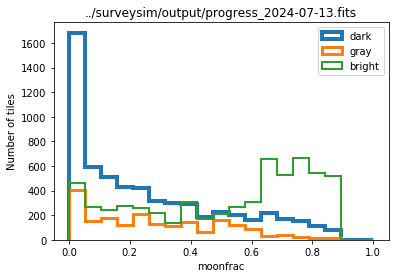

In [140]:
plot_surveyplan(progress_files[-1])

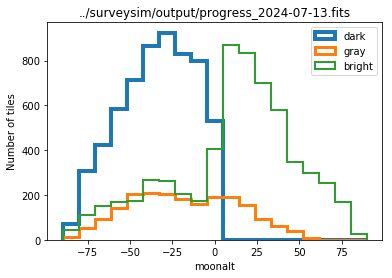

In [141]:
plot_surveyplan(progress_files[-1], column='moonalt', min_val=-90, max_val=90)

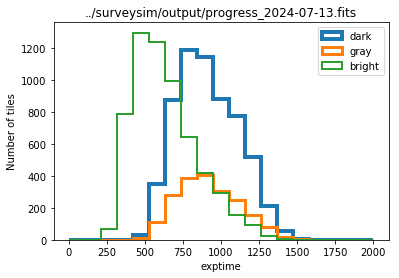

In [142]:
plot_surveyplan(progress_files[-1], column='exptime', min_val=0, max_val=2000)

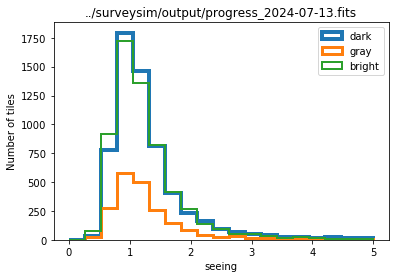

In [143]:
plot_surveyplan(progress_files[-1], column='seeing', min_val=0, max_val=5)

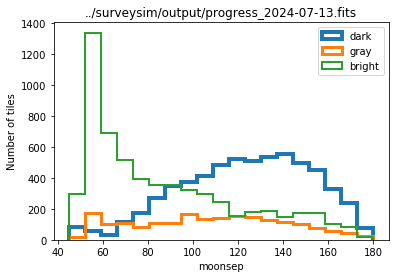

In [150]:
plot_surveyplan(progress_files[-1], column='moonsep', min_val=45, max_val=180)